#Makemore Class

Makemore is a character-level language model. Treats every single line as an example, and within eaxh example is treating them all as sequences of individual characters. The model knows how to predict the next character in the sequence.

###Exploring dataset

In [1]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines() #splitlines: get data as a Python list of strings

--2023-10-16 06:59:25--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2023-10-16 06:59:25 (4.66 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
print ('#Words: ',len(words))
print ('Shortest word: ', min(len(w) for w in words))
print ('Longest word: ', max(len(w) for w in words))

#Words:  32033
Shortest word:  2
Longest word:  15


###Bigram Language model: Two characters at a time

In [ ]:
b = {} #dictionary to count how often a pair of bigram appears
for w in words[:3]:
  chs = ['<S>'] + list(w) + ['<E>'] #Special Start and End elements
  for ch1, ch2 in zip(chs, chs[1:]): #zip takes two iterators, pairs them up and returns an iterator over the tuples of their consecutive entries
    bigram = (ch1, ch2) #tuple
    b[bigram] = b.get(bigram, 0) + 1  #dictionary.get(keyname, value)
                                      #by default 0; +1 to count
    print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [ ]:
b

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

Do it for all the words

In [ ]:
b = {} #dictionary[pair of bigrams, count] (key,value)
for w in words:
  chs = ['<S>'] + list(w) + ['<E>'] #Special Start and End elements
  for ch1, ch2 in zip(chs, chs[1:]): #zip takes two iterators, pairs them up and returns an iterator over the tuples of their consecutive entries
    bigram = (ch1, ch2) #tuple
    b[bigram] = b.get(bigram, 0) + 1  #dictionary.get(keyname, value)
                                      #by default 0; +1 to count

In [ ]:
sorted(b.items(), key = lambda kv: -kv[1]) #take kv (key value not at [0] –key– but at [1] –value–)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

Instead of using a dictionary, we will use a Python  bidimensional array. Rows are first character and columns second character. Each entry in this two-dimensioanl array will tell us how often the second character follows the first in the dataset.

In [ ]:
import torch

In [ ]:
N = torch.zeros((27, 27), dtype =torch.int32)   #array of 26 letters+start+ending
                                                #we'll be using integers, not floats

In [ ]:
chars = sorted(list(set(''.join(words)))) #sorted alphabet

#we need a lookup table from string characters (dictionary) to integers (two-dimensional array)
stoi = {s:i+1 for i,s in enumerate(chars)} # s to i mapping
#set special characters
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} #reversed mapping: i to s

In [ ]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    #map ch1 and ch2 into their integers
    ix1 = stoi[ch1] #indexing
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

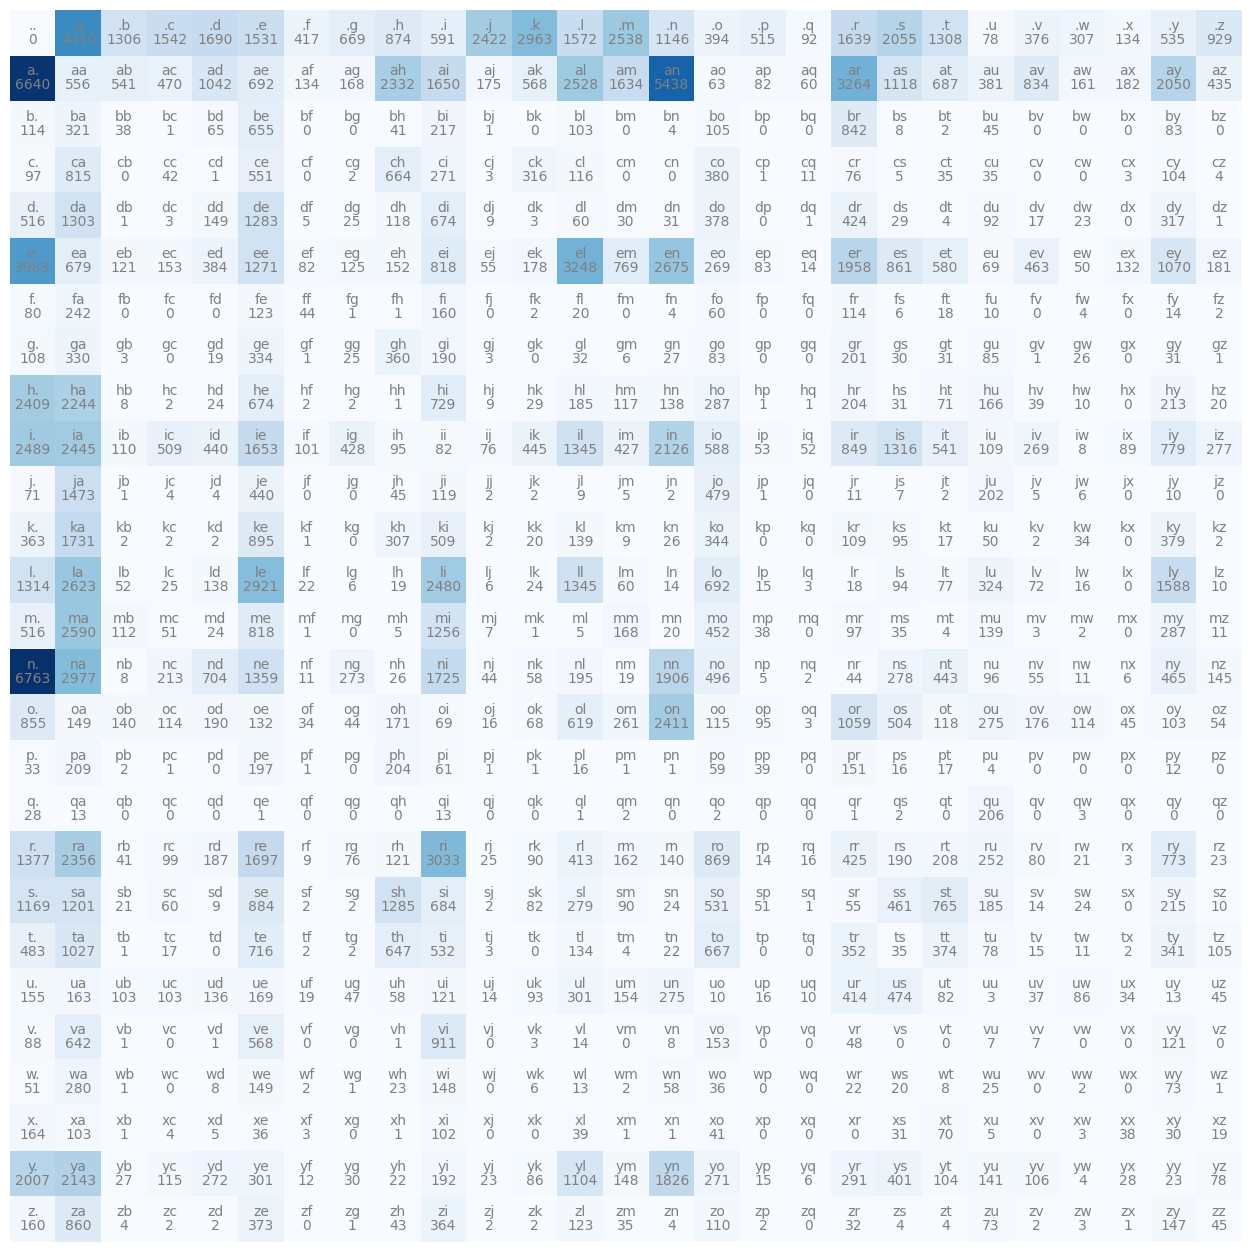

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j] #character string
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray') #plot bigram text
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray') # number of times bigram occurs
                                                                            # we need .item() to recover the content of the Tensor
plt.axis('off');

In [ ]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [ ]:
p=N[0].float() #convert integers to float so we can normalize the counts and assign probabilities
p = p/p.sum() #probability of every single character to be the first in a word
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

Multinomial gives integers sampled according to the multinomial probability distribution
Generator object makes everything deterministic

In [ ]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p #torch tensor of prob. distribution. First element is tho most probable one

tensor([0.6064, 0.3033, 0.0903])

In [ ]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

We will now sample from probability distribution p

In [ ]:
p=N[0].float() #convert integers to float so we can normalize the counts and assign probabilities
p = p/p.sum() #probability of every single character to be the first in a word
p

g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() #index
itos[ix]

'j'

In [ ]:
#P is a matrix in which we already calculate the normalised probabilities, such that we don't need to do it in every iteration of the for loop
P = (N+1).float() #add a count of 1 for model smoothing: avoid a probability = 0 and a log(prob)=infinite
P /= P.sum(1, keepdim=True) #this operation is broadcastable (either one of the dimensions is 1, it does not exist, or both dimensions are equal. See documentation: https://pytorch.org/docs/stable/notes/broadcasting.html)
#with keepdim=False, the division would also be broadcastable ([27, 27] / [ , 27]) since the non existing dimension would be considered as a 1, such that
# [27, 27] / [1, 27]. However, this will be a ROW vector with the sum over the columns, not the rows, and would give us an incorrect result.

In [ ]:
P.sum(1, keepdim=True).shape
P.shape

torch.Size([27, 27])

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  out = []
  ix = 0
  while True:
    p = P[ix]
    #p = N[ix].float() #fetching a row of Ns
    #p = p /p.sum() #normalize
    #p = torch.ones(27) / 27.0 #Uniform distribution, with everything equally likely. Output will be an untrained model.
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


We'd like to evaluate the quality of this model. To do so, we can evaluate the training loss: a single number referncing the quality of the model. We can use the negative log likelihood as our loss function.

Likelihood is the product of all the probabilities, so log(likelihood) is the sum of all the log(prob).
log(a*b*c) = log(a)+log(b)+log(c)

In [ ]:
log_likelihood = 0.0
n = 0 #counts for averaging
for w in ["daniel"]: #Test the probability of any string
#for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    #map ch1 and ch2 into their integers
    ix1 = stoi[ch1] #indexing
    ix2 = stoi[ch2]
    prob = P[ix1, ix2] #probability that the model assign to the bigram [ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n +=1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood = }')
nll = -log_likelihood #negative log likelihood is our loss function
print(f'{nll=}')
print('average log likelihood = ', f'{nll/n}') #average log likelihood (normalised)

.d: 0.0527 -2.9423
da: 0.2361 -1.4435
an: 0.1604 -1.8302
ni: 0.0940 -2.3640
ie: 0.0933 -2.3719
el: 0.1589 -1.8396
l.: 0.0940 -2.3641
log_likelihood = tensor(-15.1557)
nll=tensor(15.1557)
average log likelihood =  2.1651031970977783


GOAL of training: maximize likelihood of the data w.r.t. model parameters (statistical modeling)

equivalent to maximizing the log likelihood (because log is monotonic)

equivalent to minimizing the negative log likelihood

equivalent to minimizing the average negative log likelihood

The lower it is, the better the model, because it will be assigning high probabilities to certain combinations of characters.

#Part 2: Neural network
We already have a bigram character-level language model. We assigned probabilities to every combination of characters and performed sampling to create new names. We also evaluated the quality of the model with the negative log likelihood (summarizing in a single number) loss function.




We can take an alternative approach to achieve the same results. We can cast the problem of bigram character-level language modeling into the neural network framework.
The neural network is going to receive a character as an input, have weights, parameters, biases, etc. and output the probability distribution over the next character in a sequence. We will use gradient-based optimization.

In [ ]:
#create the training set of bigrams (x,y), made of two lists
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    #map ch1 and ch2 into their integers
    ix1 = stoi[ch1] #indexing
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs) #xs.dtype changes when using torch.tensor (integers) and torch.Tensor (floats)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys #for character 0 ('.'), it is likely to have output 5 ('e')

tensor([ 5, 13, 13,  1,  0])

One-hot encoding (To represent integer n, every bit is 0 except for the nth bit) encodes integers into vectors to feed the neural network.

In [ ]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() #x-encoded. Casted to float
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc.shape

torch.Size([5, 27])

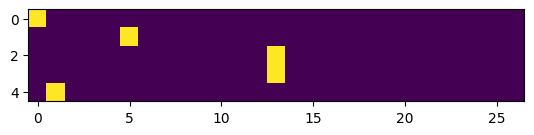

In [ ]:
plt.imshow(xenc)

Let's construct the first neuron:

In [ ]:
W = torch.randn((27,27)) #create 27 neurons
xenc @ W # @ is matrix multiplication operator in Pytorch
#(5, 27) @ (27, 27) -> (5, 27)

tensor([[-0.5023,  0.2737, -0.7040,  1.2859, -1.2839, -0.0954, -1.4243, -1.9242,
         -1.4305, -0.3720, -2.2555,  0.0437,  0.5143, -1.7029,  0.2167, -0.1636,
          1.2915,  0.7253, -0.3544,  0.0930,  0.0731, -1.5825,  1.3939, -1.3907,
         -0.1938, -1.2698,  0.3577],
        [-1.7161, -0.2245,  0.2029, -0.3998, -2.0817,  0.6146, -1.0192,  0.4130,
          1.5548, -0.3982,  0.2999,  1.5060, -0.2639, -0.6531,  0.4903,  1.1029,
         -0.7289,  0.9763, -0.2341, -1.0607, -0.7388,  1.1374, -1.7223,  0.7723,
          0.6906,  0.4122,  1.1141],
        [ 2.8094,  1.6446,  0.9895,  0.0570, -1.6142,  0.2609, -0.7156, -1.1090,
         -1.0029, -0.0374, -1.8957,  0.6420,  1.6987, -0.2327,  0.2578,  0.9591,
         -0.2608, -0.7567,  1.7598,  1.1581,  0.7161,  0.5504,  0.4272,  0.0402,
          1.2446,  0.5618, -0.4012],
        [ 2.8094,  1.6446,  0.9895,  0.0570, -1.6142,  0.2609, -0.7156, -1.1090,
         -1.0029, -0.0374, -1.8957,  0.6420,  1.6987, -0.2327,  0.2578,  0.9591

In [ ]:
(xenc @ W)[3,13] #firing rate of the 13th neuron looking at the 3rd input

tensor(-0.2327)

We will consider the output of the neural network as a log(count). To get the count and obtain probabilities, we need to exponentiate the output of the layer of 27 neurons.

After exponentiating, all the negative numbers are converted to a number below 1 (but positive).

In [ ]:
logits = (xenc @ W).exp() #log-counts
counts = logits.exp() #equivalent to N matrix (arrays of counts)
probs = counts / counts.sum(1, keepdims=True) #normalize counts to get a probability distribution
probs

tensor([[9.6051e-03, 1.9531e-02, 8.5998e-03, 1.9541e-01, 6.9178e-03, 1.3015e-02,
         6.6713e-03, 6.0686e-03, 6.6614e-03, 1.0449e-02, 5.8239e-03, 1.4907e-02,
         2.7927e-02, 6.2921e-03, 1.8158e-02, 1.2258e-02, 1.9943e-01, 4.1368e-02,
         1.0578e-02, 1.5715e-02, 1.5379e-02, 6.4405e-03, 2.9526e-01, 6.7264e-03,
         1.1953e-02, 6.9450e-03, 2.1915e-02],
        [3.4350e-03, 6.3799e-03, 9.7691e-03, 5.6109e-03, 3.2510e-03, 1.8232e-02,
         4.1170e-03, 1.3008e-02, 3.2652e-01, 5.6170e-03, 1.1067e-02, 2.6059e-01,
         6.1859e-03, 4.8292e-03, 1.4689e-02, 5.8397e-02, 4.6491e-03, 4.0809e-02,
         6.3312e-03, 4.0570e-03, 4.6271e-03, 6.4903e-02, 3.4312e-03, 2.5002e-02,
         2.1095e-02, 1.2992e-02, 6.0405e-02],
        [9.9994e-01, 1.0968e-05, 9.1034e-07, 1.7814e-07, 7.5413e-08, 2.2633e-07,
         1.0077e-07, 8.5953e-08, 8.9187e-08, 1.6193e-07, 7.1818e-08, 4.1328e-07,
         1.4633e-05, 1.3650e-07, 2.2542e-07, 8.3978e-07, 1.3353e-07, 9.8803e-08,
         2.0648e-

In [ ]:
probs[0] #probability distribution of each of the 27 character coming after a [0], a dot.

tensor([0.0096, 0.0195, 0.0086, 0.1954, 0.0069, 0.0130, 0.0067, 0.0061, 0.0067,
        0.0104, 0.0058, 0.0149, 0.0279, 0.0063, 0.0182, 0.0123, 0.1994, 0.0414,
        0.0106, 0.0157, 0.0154, 0.0064, 0.2953, 0.0067, 0.0120, 0.0069, 0.0219])

#Summary
of the feeding and output process. Feeding an 'a' into the neural network:

1- Got 'a' index (=1)
2- One-hot encode it (27 sized vector of zeroes except for 1st position, representing 'a')
3- Into the neural net
4- Out interpreted as log-counts(logit)
5- Exponentiate to eliminate negative counts
6- nrmalize to get probability distribution

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [ ]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

#Optimization of the neural network

##Example

In [2]:
xs

NameError: ignored

In [3]:
ys

NameError: ignored

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad = True)

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
# backward pass
W.grad = None #set the gradient to zero
loss.backward() #Pytorch stores all the dependencies

In [ ]:
# update
W.data += -0.1 * W.grad #negative (we want to minimize loss) learning step

In [ ]:
print(loss.item())

## Rearranged

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
#Regularization loss and model smoothing
# Same as we added 1 to eliminate bigrams wit 0 probability, we can make the matrix of parameters W close to 0 to make the probabilities more uniform
(W**2).mean()
#This term 'forces' probabilities to be uniform (W has to be close to 0).

tensor(0.9665, grad_fn=<MeanBackward0>)

In [ ]:
# gradient descent
for k in range(10):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() #regularization loss added
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

3.7686190605163574
3.3788065910339355
3.16109037399292
3.0271859169006348
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188303470611572


In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

juwjde.
janaqydjufhfbywe.
nn.
ksh.
ritoleras.


#Makemore Exercises

Makemore source code: https://github.com/karpathy/makemore
Makemore YouTube spelled-out:https://www.youtube.com/watch?v=PaCmpygFfXo&ab_channel=AndrejKarpathy

#E01 Trigram language model
Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

##Using Counting

In [ ]:
import torch

In [ ]:
N = torch.zeros((27, 27, 27), dtype =torch.int32)   #3D-array of 26 letters+start/ending


In [ ]:
chars = sorted(list(set(''.join(words)))) #sorted alphabet
stoi = {s:i+1 for i,s in enumerate(chars)} # s to i mapping: {'a':1, 'b':2,...}
stoi['.']=0
itos = {i:s for s,i in stoi.items()} #reversed mapping: i to s

In [ ]:
for w in words:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): #chs is 'emma', while chs[1:] is 'mma'
    #indexing
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    #print(ch1,ch2,ch3)
    N[ix1, ix2, ix3] += 1 #matrix of counts

In [ ]:
N[0,1,13] #frequency of string '.am'

tensor(384, dtype=torch.int32)

In [ ]:
p = (N+1).float() #cast N to floats so we can make probabilities. +1 for smoothing and eliminate 0 probability
print('#appearances of each letter after ".a " string: \n', p[0,1])
#p[0,1] = p[0,1,:]

#appearances of each letter after ".a " string: 
 tensor([  1., 208., 191.,  32., 367.,  56.,  22.,  18.,  92., 155.,  28.,  76.,
        633., 385., 624.,  11.,  18.,  10., 483., 195.,  73., 153., 244.,   7.,
         28., 174., 153.])


In [ ]:
p[0,1] /= p[0,1].sum()
print('prob of each letter after ".a " string: \n', p[0,1])
print('sum of prob: ', p[0,1].sum())

prob of each letter after ".a " string: 
 tensor([0.0002, 0.0469, 0.0430, 0.0072, 0.0827, 0.0126, 0.0050, 0.0041, 0.0207,
        0.0349, 0.0063, 0.0171, 0.1427, 0.0868, 0.1406, 0.0025, 0.0041, 0.0023,
        0.1089, 0.0439, 0.0165, 0.0345, 0.0550, 0.0016, 0.0063, 0.0392, 0.0345])
sum of prob:  tensor(1.0000)


In [ ]:
p = (N+1).float() #cast N to floats so we can make probabilities. +1 for smoothing and eliminate 0 probability
#We normalize along 3rd dimension. we will have a 2D-matrix containing probability distribution for the next character
for ix1 in range(27):
  for ix2 in range (27):
    p[ix1, ix2] /= p[ix1, ix2].sum()


In [ ]:
p[0,1]

tensor([0.0002, 0.0469, 0.0430, 0.0072, 0.0827, 0.0126, 0.0050, 0.0041, 0.0207,
        0.0349, 0.0063, 0.0171, 0.1427, 0.0868, 0.1406, 0.0025, 0.0041, 0.0023,
        0.1089, 0.0439, 0.0165, 0.0345, 0.0550, 0.0016, 0.0063, 0.0392, 0.0345])

In [ ]:
sample = torch.multinomial(p[0,1], num_samples=20, replacement=True)
#sample = torch.multinomial(p[0,1], num_samples=20, replacement=True).item()
#print(itos[sample])
sample

tensor([ 2, 14, 12, 18,  5,  4, 26, 22, 21, 12, 12,  1, 18, 12,  4,  1, 18,  5,
         4, 14])

In [ ]:
P=(N+1).float()
for ix1 in range(27):
  for ix2 in range (27):
    P[ix1, ix2] /= P[ix1, ix2].sum()

#P is now matrix of probabilities (we don't perform calculations inside the for loop)

In [ ]:
for i in range(10):
  out = []
  ix1 = 0
  ix2 = 0 #second character of first iteration is also .

  while True:
    p = P[ix1, ix2]
    ix_new = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(itos[ix_new])
    ix1 = ix2
    ix2 = ix_new
    if ix_new == 0:
      break
  print(''.join(out))

sa.
dalaylestaku.
romia.
vettuccey.
gluwermreyleya.
paya.
saidylee.
beliamahrisirfelanuria.
cygegs.
khri.


Evaluate the quality of the model.

In [ ]:
log_likelihood = 0.0
n = 0
for w in words:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): #chs is 'emma', while chs[1:] is 'mma'
    #indexing
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    prob = P[ix1, ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood = }')
nll = -log_likelihood
print(f'{nll = }')
print('average log likelihood = ', f'{nll/n}') #average log likelihood (normalised)


log_likelihood = tensor(-504653.)
nll = tensor(504653.)
average log likelihood =  2.2119739055633545


The average loss is not significantly different from the bigram model.

##Using neural net

In [4]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open('names.txt', 'r').read().splitlines() #splitlines: get data as a Python list of strings

from itertools import product
import matplotlib.pyplot as plt

--2023-10-16 06:59:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-10-16 06:59:41 (5.51 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [5]:
#create indexing of single characters 'a','b', ...
alphabet = sorted(list(set(''.join(words))))
len(alphabet)
stoi = {s:idx for idx, s in enumerate(alphabet, 1)}
stoi['.'] = 0
itos = {idx:s for s, idx in stoi.items()}
itos

##create indexing of double characters 'aa','ab', ... , 'ba', 'bb',...
alphabet_copy = alphabet.copy()
alphabet_copy.append('.')
alphabet2 = set()
for comb in product(alphabet_copy, repeat=2): #cartesian product of alphabet
  alphabet2.add("".join(comb))
alphabet_comb = sorted(list(alphabet2))
print(len(alphabet_comb))

stoi2 = {s:idx  for idx, s in enumerate(alphabet_comb)}
itos2 = {idx: s for s, idx in stoi2.items()}

729


In [ ]:
#create set of trigrams
xs, ys = [], []


for w in words[:1]:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip (chs, chs[1:], chs[2:]):
    print(f"{ch1}{ch2}-> {ch3}")
    ix1 = stoi2[ch1+ch2] #sum of characters is concatenate
    ix2 = stoi[ch3]

    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print('xs: ', xs)
print('ys: ', ys)

..-> e
.e-> m
em-> m
mm-> a
ma-> .
xs:  tensor([  0,   5, 148, 364, 352])
ys:  tensor([ 5, 13, 13,  1,  0])


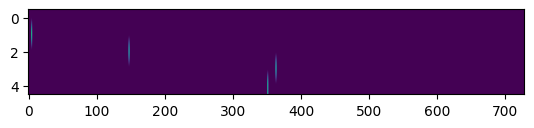

In [ ]:
#one-hot encoding
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=len(alphabet_comb)).float() #x-encoded. Casted to float

plt.imshow(xenc, aspect=25);

In [ ]:
xenc.shape

torch.Size([5, 729])

In [ ]:
#generate Weight matrix
W = torch.randn((xenc.shape[1], 27), requires_grad=True) #729(input) x 27(output)
W.shape

torch.Size([729, 27])

In [ ]:
##forward pass

logits = xenc @ W #predicted log-counts

#Softmax
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True) #probabilities for next character
probs

tensor([[0.0501, 0.0038, 0.0114, 0.0216, 0.0111, 0.0181, 0.0117, 0.1415, 0.0126,
         0.0377, 0.0653, 0.0731, 0.0303, 0.0309, 0.0662, 0.0270, 0.0107, 0.0090,
         0.0474, 0.0086, 0.0397, 0.0106, 0.0456, 0.0437, 0.0029, 0.0071, 0.1624],
        [0.0485, 0.0653, 0.0020, 0.0518, 0.0148, 0.0053, 0.0171, 0.0839, 0.0389,
         0.0513, 0.0249, 0.0495, 0.0644, 0.0204, 0.0435, 0.0904, 0.0460, 0.0091,
         0.0084, 0.0093, 0.0173, 0.0706, 0.0063, 0.0338, 0.0409, 0.0541, 0.0324],
        [0.0060, 0.1299, 0.0097, 0.3121, 0.0068, 0.0204, 0.0052, 0.0450, 0.0111,
         0.0116, 0.0395, 0.0027, 0.0145, 0.0926, 0.0338, 0.0478, 0.0072, 0.0214,
         0.0127, 0.0362, 0.0119, 0.0307, 0.0046, 0.0095, 0.0105, 0.0202, 0.0465],
        [0.0419, 0.0048, 0.0364, 0.0342, 0.0344, 0.0633, 0.0632, 0.0029, 0.0103,
         0.0469, 0.0093, 0.0235, 0.0041, 0.0192, 0.0703, 0.0275, 0.1499, 0.0237,
         0.0055, 0.0390, 0.0212, 0.0466, 0.0297, 0.0141, 0.0124, 0.0950, 0.0706],
        [0.0085, 0.0205,

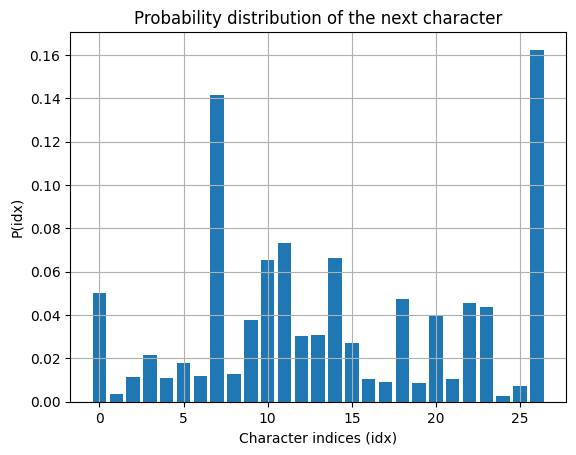

In [ ]:
plt.bar(range(27), probs[0].tolist())
plt.xlabel("Character indices (idx)")
plt.ylabel("P(idx)")
plt.title("Probability distribution of the next character")
plt.grid()

In [ ]:
#for first trigram [0], we want the probability of being the 5th index -> probs[0,5]
print(probs)
print(ys)
probs[[0,1,2], [5, 13, 13]]

tensor([[0.0501, 0.0038, 0.0114, 0.0216, 0.0111, 0.0181, 0.0117, 0.1415, 0.0126,
         0.0377, 0.0653, 0.0731, 0.0303, 0.0309, 0.0662, 0.0270, 0.0107, 0.0090,
         0.0474, 0.0086, 0.0397, 0.0106, 0.0456, 0.0437, 0.0029, 0.0071, 0.1624],
        [0.0485, 0.0653, 0.0020, 0.0518, 0.0148, 0.0053, 0.0171, 0.0839, 0.0389,
         0.0513, 0.0249, 0.0495, 0.0644, 0.0204, 0.0435, 0.0904, 0.0460, 0.0091,
         0.0084, 0.0093, 0.0173, 0.0706, 0.0063, 0.0338, 0.0409, 0.0541, 0.0324],
        [0.0060, 0.1299, 0.0097, 0.3121, 0.0068, 0.0204, 0.0052, 0.0450, 0.0111,
         0.0116, 0.0395, 0.0027, 0.0145, 0.0926, 0.0338, 0.0478, 0.0072, 0.0214,
         0.0127, 0.0362, 0.0119, 0.0307, 0.0046, 0.0095, 0.0105, 0.0202, 0.0465],
        [0.0419, 0.0048, 0.0364, 0.0342, 0.0344, 0.0633, 0.0632, 0.0029, 0.0103,
         0.0469, 0.0093, 0.0235, 0.0041, 0.0192, 0.0703, 0.0275, 0.1499, 0.0237,
         0.0055, 0.0390, 0.0212, 0.0466, 0.0297, 0.0141, 0.0124, 0.0950, 0.0706],
        [0.0085, 0.0205,

tensor([0.0181, 0.0204, 0.0926], grad_fn=<IndexBackward0>)

In [ ]:
#loss
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(probs.shape)
len(probs)

torch.Size([5, 27])


5

In [ ]:
#backward pass
W.grad = None
loss.backward()

In [ ]:
#update
W.data += -0.1 * W.grad

In [ ]:
print(loss.item())

4.076936721801758


## Trigram neural network rearranged

In [8]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open('names.txt', 'r').read().splitlines() #splitlines: get data as a Python list of strings

--2023-10-16 07:01:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-10-16 07:01:03 (4.92 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [11]:
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

In [13]:
#create indexing of single characters 'a','b', ...
alphabet = sorted(list(set(''.join(words))))
len(alphabet)
stoi = {s:idx for idx, s in enumerate(alphabet, 1)}
stoi['.'] = 0
itos = {idx:s for s, idx in stoi.items()}
itos

##create indexing of double characters 'aa','ab', ... , 'ba', 'bb',...
alphabet_copy = alphabet.copy()
alphabet_copy.append('.')
alphabet2 = set()
for comb in product(alphabet_copy, repeat=2): #cartesian product of alphabet
  alphabet2.add("".join(comb))
alphabet_comb = sorted(list(alphabet2))

stoi2 = {s:idx for idx, s in enumerate(alphabet_comb)}
itos2 = {idx: s for s, idx in stoi2.items()}

In [14]:
#create set of trigrams
xs, ys = [], []


for w in words:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip (chs, chs[1:], chs[2:]):
    #print(f"{ch1}{ch2}-> {ch3}")
    ix1 = stoi2[ch1+ch2] #sum of characters is concatenate
    ix2 = stoi[ch3]

    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
n_trigrams = len(xs)

print('xs: ', xs)
print('ys: ', ys)
print('#trigrams: ', n_trigrams)

xs:  tensor([  0,   5, 148,  ..., 727, 701, 726])
ys:  tensor([ 5, 13, 13,  ..., 26, 24,  0])
#trigrams:  228146


In [15]:
# train with gradient descent
xenc = F.one_hot(xs, num_classes=len(alphabet_comb)+1).float() #x-encoded. Casted to float
W = torch.randn((xenc.shape[1], 27), requires_grad=True) #729(input) x 27(output)

train_loss (final): 2.3924484252929688


[]

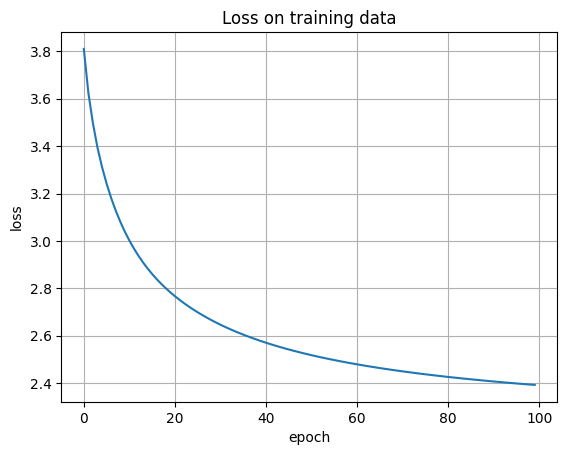

In [ ]:
N_ITERS = 100
LEARN_RATE = 100
REG = 0.01 #regularization
losses = []

for k in range (N_ITERS):

  #forward pass
  logits = xenc @ W #predicted log-counts
  #Softmax
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True) #probabilities for next character
  loss = -probs[torch.arange(n_trigrams), ys].log().mean() + REG*(W**2).mean()
  #print(loss.item())
  losses.append(loss.data)


  #backward pass
  W.grad = None #set gradient to zero
  loss.backward()

  #update
  W.data -= LEARN_RATE * W.grad

print(f"train_loss (final): {losses[-1]}")
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid()
plt.plot()

In [ ]:
#sample from the neural net model

for i in range(5):
  out = []
  ix = 0

  while True:
    #one-hot encode input
    xenc = F.one_hot(torch.tensor([ix]), num_classes=len(alphabet_comb)+1).float() #create a tensor with the last character (starts from 0) and one-hot encode it

    #make prediction
    logits = xenc @ W #predict log-counts
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    #sample from prob. distribution
    sampled_ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(itos[sampled_ix])

    #rearrange indexes
    last_char = itos2[ix][-1] #last character read in this iteration
    predicted_char = itos[sampled_ix]
    ix = stoi2[last_char + predicted_char]


    if sampled_ix == 0:
      break
  print(''.join(out))

niveoiozalan.
matmmarli.
ann.
dodi.
kalynni.


In [ ]:
itos2[0][-1]

'.'

#E02
split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?


In [16]:
from sklearn.model_selection import train_test_split

def split_data (xs, ys):
  x_train, x_aux, y_train, y_aux = train_test_split(xs, ys, test_size=0.2, random_state=1)
  x_val, x_test, y_val, y_test = train_test_split(x_aux, y_aux, test_size=0.5, random_state=1)

  return (x_train, y_train, x_val, y_val, x_test, y_test)

##Bigram model

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

x_train, y_train, x_val, y_val, x_test, y_test = split_data(xs, ys)

# initialize the 'network'
W = torch.randn((27, 27), requires_grad=True)

In [ ]:
print('Total #elements: ', len(xs))
print('size of train set: ', len(x_train))
print('size of dev set: ', len(x_val))
print('size of test set: ', len(x_test))

Total #elements:  228146
size of train set:  182516
size of dev set:  22815
size of test set:  22815


train_loss (final): 2.511627197265625
validation_loss (final): 2.5075109004974365
test_loss (final): 2.5017035007476807


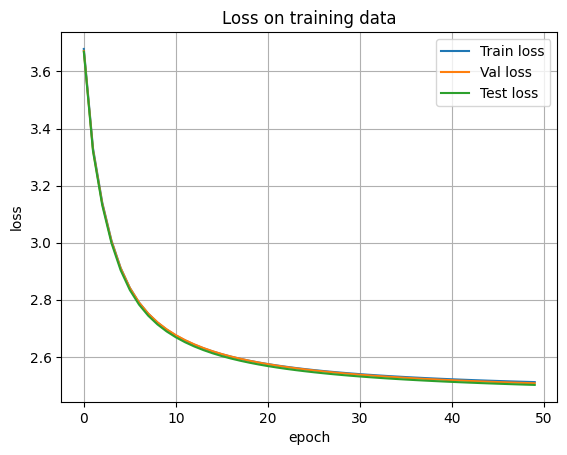

In [ ]:
# gradient descent
N_ITERS = 50
LEARN_RATE = 50
REG = 0.01 #regularization
train_losses = []
val_losses = []
test_losses = []

xenc_train = F.one_hot(x_train, num_classes=27).float() # input to the network one-hot encoded
xenc_val = F.one_hot(x_val, num_classes=27).float()
xenc_test = F.one_hot(x_test, num_classes=27).float()


for k in range(N_ITERS):

  # forward pass
  logits = xenc_train @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

  #loss
  train_loss = -probs[torch.arange(len(x_train)), y_train].log().mean() + REG*(W**2).mean() #regularization loss added
  train_losses.append(train_loss.data)

  with torch.no_grad():
        logits_val = xenc_val @ W # predict log-counts
        counts_val = logits_val.exp()
        probs_val = counts_val / counts_val.sum(1, keepdims=True)
        val_loss = -1 * probs_val[torch.arange(len(xenc_val)), y_val].log().mean()
        val_losses.append(val_loss)

        logits_test = xenc_test @ W
        counts_test = logits_test.exp()
        probs_test = counts_test / counts_test.sum(1, keepdims=True)
        test_loss = -1 * probs_test[torch.arange(len(xenc_test)), y_test].log().mean()
        test_losses.append(test_loss)



  # backward pass
  W.grad = None # set to zero the gradient
  train_loss.backward()

  # update
  W.data -= LEARN_RATE * W.grad


print(f"train_loss (final): {train_losses[-1]}")
print(f"validation_loss (final): {val_losses[-1]}")
print(f"test_loss (final): {test_losses[-1]}")

plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.plot(test_losses, label='Test loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid()
plt.legend()
plt.plot();

## Trigram model

In [ ]:
#create indexing of single characters 'a','b', ...
alphabet = sorted(list(set(''.join(words))))
len(alphabet)
stoi = {s:idx for idx, s in enumerate(alphabet, 1)}
stoi['.'] = 0
itos = {idx:s for s, idx in stoi.items()}
itos

##create indexing of double characters 'aa','ab', ... , 'ba', 'bb',...
alphabet_copy = alphabet.copy()
alphabet_copy.append('.')
alphabet2 = set()
for comb in product(alphabet_copy, repeat=2): #cartesian product of alphabet
  alphabet2.add("".join(comb))
alphabet_comb = sorted(list(alphabet2))

stoi2 = {s:idx for idx, s in enumerate(alphabet_comb)}
itos2 = {idx: s for s, idx in stoi2.items()}



#create set of trigrams
xs, ys = [], []

for w in words:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip (chs, chs[1:], chs[2:]):
    #print(f"{ch1}{ch2}-> {ch3}")
    ix1 = stoi2[ch1+ch2] #sum of characters is concatenate
    ix2 = stoi[ch3]

    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
n_trigrams = len(xs)

print('xs: ', xs)
print('ys: ', ys)
print('#trigrams: ', n_trigrams)

#split data
x_train, y_train, x_val, y_val, x_test, y_test = split_data(xs, ys)

xs:  tensor([  0,   5, 148,  ..., 727, 701, 726])
ys:  tensor([ 5, 13, 13,  ..., 26, 24,  0])
#trigrams:  228146


In [ ]:
print('Total #elements: ', len(xs))
print('size of train set: ', len(x_train))
print('size of dev set: ', len(x_val))
print('size of test set: ', len(x_test))

Total #elements:  228146
size of train set:  182516
size of dev set:  22815
size of test set:  22815


train_loss (final): 2.699500322341919
validation_loss (final): 2.6992602348327637
test_loss (final): 2.69442081451416


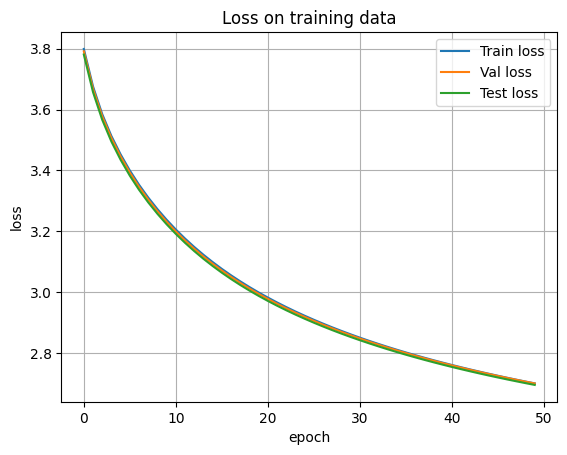

In [ ]:
# gradient descent
N_ITERS = 50
LEARN_RATE = 50
REG = 0.01 #regularization
train_losses = []
val_losses = []
test_losses = []


xenc_train = F.one_hot(x_train, num_classes=len(alphabet_comb)).float() #x-encoded. Casted to float
xenc_val = F.one_hot(x_val, num_classes=len(alphabet_comb)).float()
xenc_test = F.one_hot(x_test, num_classes=len(alphabet_comb)).float()

#initialize the network
W = torch.randn((xenc_train.shape[1], 27), requires_grad=True) #729(input) x 27(output)


#gradient descent
for k in range(N_ITERS):

  # forward pass
  logits = xenc_train @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

  #loss
  train_loss = -probs[torch.arange(len(xenc_train)), y_train].log().mean() + REG*(W**2).mean() #regularization loss added
  train_losses.append(train_loss.data)

  with torch.no_grad():
        logits_val = xenc_val @ W # predict log-counts
        counts_val = logits_val.exp()
        probs_val = counts_val / counts_val.sum(1, keepdims=True)
        val_loss = -1 * probs_val[torch.arange(len(xenc_val)), y_val].log().mean()
        val_losses.append(val_loss)

        logits_test = xenc_test @ W
        counts_test = logits_test.exp()
        probs_test = counts_test / counts_test.sum(1, keepdims=True)
        test_loss = -1 * probs_test[torch.arange(len(xenc_test)), y_test].log().mean()
        test_losses.append(test_loss)



  # backward pass
  W.grad = None # set to zero the gradient
  train_loss.backward()

  # update
  W.data -= LEARN_RATE * W.grad


print(f"train_loss (final): {train_losses[-1]}")
print(f"validation_loss (final): {val_losses[-1]}")
print(f"test_loss (final): {test_losses[-1]}")

plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.plot(test_losses, label='Test loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid()
plt.legend()
plt.plot();

The model seems to underfit the training data, since both validation and test loss are similar to the training loss.

#E03
Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?


In [ ]:
#create indexing of single characters 'a','b', ...
alphabet = sorted(list(set(''.join(words))))
len(alphabet)
stoi = {s:idx for idx, s in enumerate(alphabet, 1)}
stoi['.'] = 0
itos = {idx:s for s, idx in stoi.items()}
itos

##create indexing of double characters 'aa','ab', ... , 'ba', 'bb',...
alphabet_copy = alphabet.copy()
alphabet_copy.append('.')
alphabet2 = set()
for comb in product(alphabet_copy, repeat=2): #cartesian product of alphabet
  alphabet2.add("".join(comb))
alphabet_comb = sorted(list(alphabet2))

stoi2 = {s:idx for idx, s in enumerate(alphabet_comb)}
itos2 = {idx: s for s, idx in stoi2.items()}



#create set of trigrams
xs, ys = [], []

for w in words:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip (chs, chs[1:], chs[2:]):
    #print(f"{ch1}{ch2}-> {ch3}")
    ix1 = stoi2[ch1+ch2] #sum of characters is concatenate
    ix2 = stoi[ch3]

    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
n_trigrams = len(xs)

print('xs: ', xs)
print('ys: ', ys)
print('#trigrams: ', n_trigrams)

#split data
x_train, y_train, x_val, y_val, x_test, y_test = split_data(xs, ys)

xs:  tensor([  0,   5, 148,  ..., 727, 701, 726])
ys:  tensor([ 5, 13, 13,  ..., 26, 24,  0])
#trigrams:  228146


In [ ]:
xenc_train = F.one_hot(x_train, num_classes=len(alphabet_comb)).float() #x-encoded. Casted to float
xenc_val = F.one_hot(x_val, num_classes=len(alphabet_comb)).float()
xenc_test = F.one_hot(x_test, num_classes=len(alphabet_comb)).float()

In [ ]:
from tqdm import tqdm
import numpy as np

# gradient descent
N_ITERS = 5
LEARN_RATE = 100


reg_strenghts = np.arange(0,0.8,0.02)

loss_dict = {} # <reg_strength: [final train loss, final val loss]>
W = torch.randn((729, 27), requires_grad=True) #729(input) x 27(output)

for REG in tqdm(reg_strenghts):

  train_losses = []
  val_losses = []
  test_losses = []

  W = torch.randn((729, 27), requires_grad=True) #729(input) x 27(output)


  #gradient descent
  for k in range(N_ITERS):

    # forward pass
    logits = xenc_train @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

    #loss
    train_loss = -probs[torch.arange(len(xenc_train)), y_train].log().mean() + REG*(W**2).mean() #regularization loss added
    train_losses.append(train_loss.data)

    with torch.no_grad():
          logits_val = xenc_val @ W # predict log-counts
          counts_val = logits_val.exp()
          probs_val = counts_val / counts_val.sum(1, keepdims=True)
          val_loss = -1 * probs_val[torch.arange(len(xenc_val)), y_val].log().mean()
          val_losses.append(val_loss)


    # backward pass
    W.grad = None # set to zero the gradient
    train_loss.backward()

    # update
    W.data -= LEARN_RATE * W.grad

  print('train loss: ',train_losses[-1])
  print('val loss: ',val_losses[-1])
  loss_dict[REG] = [train_losses[-1], val_losses[-1]]


  2%|▎         | 1/40 [00:03<02:19,  3.58s/it]

train loss:  tensor(3.2676)
val loss:  tensor(3.2664)


  5%|▌         | 2/40 [00:06<02:07,  3.34s/it]

train loss:  tensor(3.2585)
val loss:  tensor(3.2409)


  8%|▊         | 3/40 [00:09<01:57,  3.16s/it]

train loss:  tensor(3.2989)
val loss:  tensor(3.2598)


 10%|█         | 4/40 [00:12<01:50,  3.07s/it]

train loss:  tensor(3.2768)
val loss:  tensor(3.2213)


 12%|█▎        | 5/40 [00:16<01:52,  3.21s/it]

train loss:  tensor(3.3940)
val loss:  tensor(3.3263)


 15%|█▌        | 6/40 [00:19<01:49,  3.22s/it]

train loss:  tensor(3.3997)
val loss:  tensor(3.3058)


 18%|█▊        | 7/40 [00:22<01:43,  3.12s/it]

train loss:  tensor(3.3954)
val loss:  tensor(3.2894)


 20%|██        | 8/40 [00:25<01:38,  3.07s/it]

train loss:  tensor(3.4325)
val loss:  tensor(3.2956)


 22%|██▎       | 9/40 [00:28<01:38,  3.18s/it]

train loss:  tensor(3.4068)
val loss:  tensor(3.2615)


 25%|██▌       | 10/40 [00:31<01:36,  3.22s/it]

train loss:  tensor(3.4237)
val loss:  tensor(3.2604)


 28%|██▊       | 11/40 [00:34<01:30,  3.14s/it]

train loss:  tensor(3.4504)
val loss:  tensor(3.2613)


 30%|███       | 12/40 [00:37<01:26,  3.08s/it]

train loss:  tensor(3.4276)
val loss:  tensor(3.2150)


 32%|███▎      | 13/40 [00:41<01:25,  3.17s/it]

train loss:  tensor(3.4428)
val loss:  tensor(3.2221)


 35%|███▌      | 14/40 [00:44<01:23,  3.23s/it]

train loss:  tensor(3.4707)
val loss:  tensor(3.2170)


 38%|███▊      | 15/40 [00:47<01:18,  3.14s/it]

train loss:  tensor(3.5001)
val loss:  tensor(3.2218)


 40%|████      | 16/40 [00:50<01:14,  3.08s/it]

train loss:  tensor(3.5341)
val loss:  tensor(3.2566)


 42%|████▎     | 17/40 [00:53<01:12,  3.15s/it]

train loss:  tensor(3.5839)
val loss:  tensor(3.2800)


 45%|████▌     | 18/40 [00:57<01:10,  3.23s/it]

train loss:  tensor(3.5836)
val loss:  tensor(3.2608)


 48%|████▊     | 19/40 [01:00<01:10,  3.36s/it]

train loss:  tensor(3.6339)
val loss:  tensor(3.2984)


 50%|█████     | 20/40 [01:03<01:05,  3.27s/it]

train loss:  tensor(3.6085)
val loss:  tensor(3.2569)


 52%|█████▎    | 21/40 [01:07<01:03,  3.35s/it]

train loss:  tensor(3.6720)
val loss:  tensor(3.2889)


 55%|█████▌    | 22/40 [01:10<00:59,  3.29s/it]

train loss:  tensor(3.6768)
val loss:  tensor(3.2743)


 57%|█████▊    | 23/40 [01:13<00:54,  3.18s/it]

train loss:  tensor(3.6458)
val loss:  tensor(3.2270)


 60%|██████    | 24/40 [01:16<00:49,  3.11s/it]

train loss:  tensor(3.6835)
val loss:  tensor(3.2529)


 62%|██████▎   | 25/40 [01:20<00:48,  3.23s/it]

train loss:  tensor(3.7107)
val loss:  tensor(3.2544)


 65%|██████▌   | 26/40 [01:23<00:45,  3.22s/it]

train loss:  tensor(3.7520)
val loss:  tensor(3.2795)


 68%|██████▊   | 27/40 [01:26<00:40,  3.14s/it]

train loss:  tensor(3.7520)
val loss:  tensor(3.2546)


 70%|███████   | 28/40 [01:29<00:37,  3.08s/it]

train loss:  tensor(3.7493)
val loss:  tensor(3.2609)


 72%|███████▎  | 29/40 [01:32<00:35,  3.19s/it]

train loss:  tensor(3.7977)
val loss:  tensor(3.2766)


 75%|███████▌  | 30/40 [01:35<00:32,  3.21s/it]

train loss:  tensor(3.7551)
val loss:  tensor(3.2097)


 78%|███████▊  | 31/40 [01:38<00:28,  3.13s/it]

train loss:  tensor(3.7777)
val loss:  tensor(3.2312)


 80%|████████  | 32/40 [01:41<00:24,  3.07s/it]

train loss:  tensor(3.8301)
val loss:  tensor(3.2578)


 82%|████████▎ | 33/40 [01:45<00:22,  3.16s/it]

train loss:  tensor(3.8741)
val loss:  tensor(3.2924)


 85%|████████▌ | 34/40 [01:48<00:19,  3.21s/it]

train loss:  tensor(3.8718)
val loss:  tensor(3.2464)


 88%|████████▊ | 35/40 [01:51<00:15,  3.12s/it]

train loss:  tensor(3.8427)
val loss:  tensor(3.2233)


 90%|█████████ | 36/40 [01:54<00:12,  3.07s/it]

train loss:  tensor(3.8591)
val loss:  tensor(3.2169)


 92%|█████████▎| 37/40 [01:57<00:09,  3.15s/it]

train loss:  tensor(3.8771)
val loss:  tensor(3.2167)


 95%|█████████▌| 38/40 [02:00<00:06,  3.22s/it]

train loss:  tensor(3.9360)
val loss:  tensor(3.2530)


 98%|█████████▊| 39/40 [02:03<00:03,  3.14s/it]

train loss:  tensor(3.9337)
val loss:  tensor(3.2349)


100%|██████████| 40/40 [02:06<00:00,  3.17s/it]

train loss:  tensor(3.9454)
val loss:  tensor(3.2249)


[]

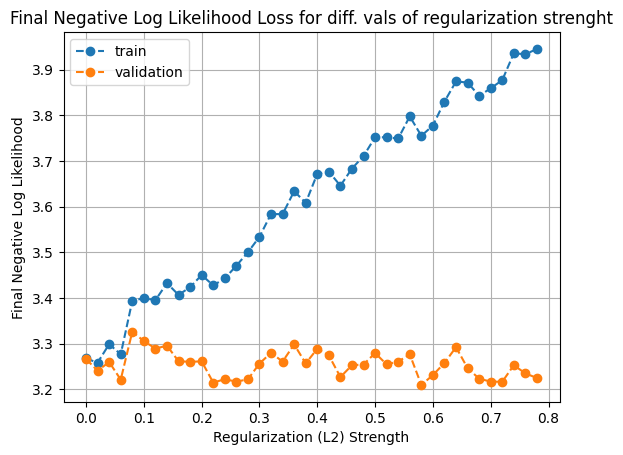

In [ ]:
plt.title(f"Final Negative Log Likelihood Loss for diff. vals of regularization strenght")
plt.plot(list(loss_dict.keys()), [train_loss for train_loss, _ in loss_dict.values()], "o--", label='train')
plt.plot(list(loss_dict.keys()), [val_loss for _, val_loss in loss_dict.values()], "o--", label='validation')
plt.xlabel("Regularization (L2) Strength")
plt.ylabel("Final Negative Log Likelihood")
plt.legend()
plt.grid()
plt.plot()

Ideally, we would like to find the regularization term that minimizes the loss, both on train and validation.

In [ ]:
a=list(loss_dict.values())[0]
a

[tensor(3.2676), tensor(3.2664)]

In [ ]:
train_loss_total = []
val_loss_total = []
total_loss = []
for train_loss, val_loss in loss_dict.values():
  train_loss_total.append(train_loss)
  val_loss_total.append(val_loss)
  total_loss.append((train_loss+val_loss).item())

#index of the minimum loss (train+validation)
idx = total_loss.index(min(total_loss))


print('Val loss = ', train_loss_total[idx].item())
print('Train loss = ', val_loss_total[idx].item())

print('Best REG value = ', reg_strenghts[idx])
print('Found on iteration',idx)

Val loss =  3.2767608165740967
Train loss =  3.221332550048828
Best REG value =  0.06
Found on iteration 3


#E04
We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?


In [17]:
#create indexing of single characters 'a','b', ...
alphabet = sorted(list(set(''.join(words))))
len(alphabet)
stoi = {s:idx for idx, s in enumerate(alphabet, 1)}
stoi['.'] = 0
itos = {idx:s for s, idx in stoi.items()}
itos

##create indexing of double characters 'aa','ab', ... , 'ba', 'bb',...
alphabet_copy = alphabet.copy()
alphabet_copy.append('.')
alphabet2 = set()
for comb in product(alphabet_copy, repeat=2): #cartesian product of alphabet
  alphabet2.add("".join(comb))
alphabet_comb = sorted(list(alphabet2))

stoi2 = {s:idx for idx, s in enumerate(alphabet_comb)}
itos2 = {idx: s for s, idx in stoi2.items()}



#create set of trigrams
xs, ys = [], []

for w in words:
  chs = '..' + w + '.'
  for ch1, ch2, ch3 in zip (chs, chs[1:], chs[2:]):
    #print(f"{ch1}{ch2}-> {ch3}")
    ix1 = stoi2[ch1+ch2] #sum of characters is concatenate
    ix2 = stoi[ch3]

    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
n_trigrams = len(xs)

print('xs: ', xs)
print('ys: ', ys)
print('#trigrams: ', n_trigrams)

#split data
x_train, y_train, x_val, y_val, x_test, y_test = split_data(xs, ys)

xs:  tensor([  0,   5, 148,  ..., 727, 701, 726])
ys:  tensor([ 5, 13, 13,  ..., 26, 24,  0])
#trigrams:  228146


We are performing the operation:

x_enc = one-hot x[idx]

logits = x_enc_i @ w

logits = [0, 1, 0, 0, ...] @ w

logits = w[1, :]


We would achieve the sme result by just:

logits = W[idx,:]

train_loss (final): 2.7429087162017822


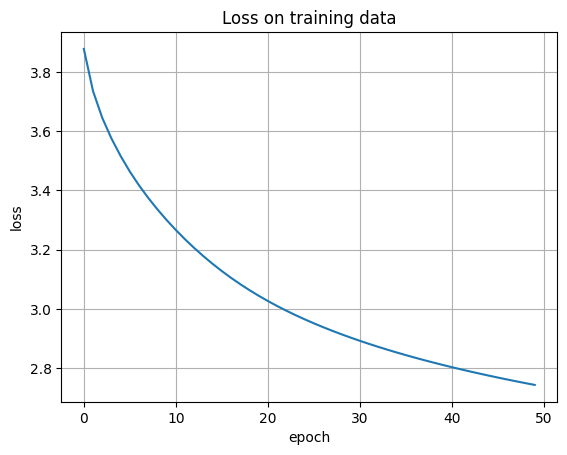

In [63]:
# gradient descent
N_ITERS = 50
LEARN_RATE = 50
REG = 0.06 #regularization
train_losses = []


#xenc_train = F.one_hot(x_train, num_classes=len(alphabet_comb)).float() #x-encoded. Casted to float

#initialize the network
W = torch.randn((len(x_train), 27), requires_grad=True) #729(input) x 27(output)


#gradient descent
for k in range(N_ITERS):

  # forward pass
  #------------
  #before
  #logits = xenc_train @ W # predict log-counts
  #-------------

  #-------------
  #now
  logits = W[x_train,:]
  #-------------

  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

  #loss
  train_loss = -probs[torch.arange(len(x_train)), y_train].log().mean() + REG*(W**2).mean() #regularization loss added
  train_losses.append(train_loss.data)

  # backward pass
  W.grad = None # set to zero the gradient
  train_loss.backward()

  # update
  W.data -= LEARN_RATE * W.grad


print(f"train_loss (final): {train_losses[-1]}")


plt.plot(train_losses, label='Train loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid()
plt.plot();

#E05
Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

train_loss (final): 2.6851704120635986


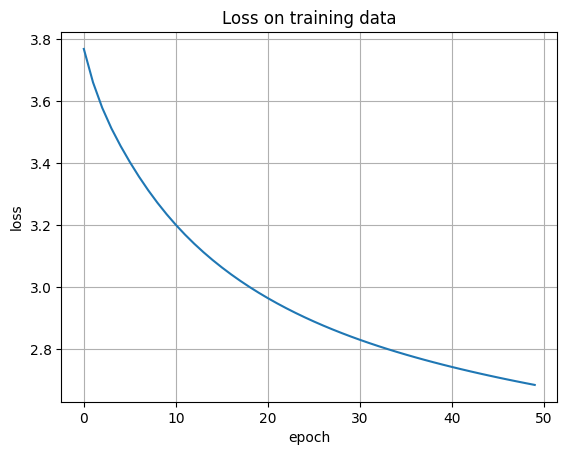

In [70]:
# gradient descent
N_ITERS = 50
LEARN_RATE = 50
REG = 0.06 #regularization
train_losses = []


#initialize the network
W = torch.randn((len(x_train), 27), requires_grad=True) #729(input) x 27(output)


#gradient descent
for k in range(N_ITERS):

  # forward pass
  logits = W[x_train,:]

  #-------------
  #BEFORE

  #counts = logits.exp() # counts, equivalent to N
  #probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  #train_loss = -probs[torch.arange(len(x_train)), y_train].log().mean() + REG*(W**2).mean() #regularization loss added

  #--------------

  #now
  train_loss = F.cross_entropy(input=logits, target=y_train)


  train_losses.append(train_loss.data)

  # backward pass
  W.grad = None # set to zero the gradient
  train_loss.backward()

  # update
  W.data -= LEARN_RATE * W.grad


print(f"train_loss (final): {train_losses[-1]}")


plt.plot(train_losses, label='Train loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid()
plt.plot();

In [73]:
%%timeit
loss = F.cross_entropy(input=logits, target=y_train)

35.8 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
train_loss = -probs[torch.arange(len(x_train)), y_train].log().mean() + REG*(W**2).mean()

46.9 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Same results using less lines of code.